In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy
import gc
import os
from glob import glob
import pickle
import random
import shutil
import seaborn as sns
from collections import Counter

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_val_score, train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import roc_auc_score, f1_score, log_loss, accuracy_score, matthews_corrcoef
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter(action              = 'ignore', category = FutureWarning)
warnings.simplefilter(action              = 'ignore', category = DeprecationWarning)
warnings.simplefilter(action              = 'ignore', category = UserWarning)
warnings.simplefilter(action              = 'ignore', category = RuntimeWarning)
warnings.filterwarnings("ignore", message = "numpy.dtype size changed")
warnings.filterwarnings("ignore", message = "numpy.ufunc size changed")
pd.options.mode.chained_assignment = None

In [2]:
train_data = np.load("./data/train.npz", allow_pickle=True)
train_data = train_data['train']

train_data.shape

(400, 2)

In [3]:
X = train_data[:100, 0]
dtrain = [i.flatten()  for i in X]
target = train_data[:100, 1]

In [4]:
test_data = np.load("./data/test.npz", allow_pickle=True)
test_data = test_data['test']

test_data.shape

(601,)

In [5]:
dtest = [i.flatten()  for i in test_data]

In [6]:
dtrain = np.array(dtrain)
dtest = np.array(dtest)

In [7]:
use = ['x_' + str(f) for f in range(dtrain.shape[1])]

dtrain = pd.DataFrame(dtrain, columns = use)
dtrain['target'] = target

dtest = pd.DataFrame(dtest, columns = use)

In [8]:
dtrain.shape, dtest.shape

((100, 116380), (601, 116379))

In [9]:
dtrain.head()

x_0        x_1       x_2        x_3        x_4       x_5        x_6  \
0 -12.568300  -5.545469  7.304270  -2.542295  16.209188  8.723945   7.204814   
1   1.809375  -5.568750  3.113327   1.661836  -5.567539  3.089362   1.516445   
2 -14.791308 -10.746484  9.721252 -15.049731 -10.389766  9.723750 -15.299448   
3  10.573271 -12.161767  8.568655   7.393847  -8.930312  6.164613   6.548662   
4   8.062422  14.520190  8.830832  -1.427363  -5.454453  2.997852  -1.573184   

         x_7       x_8        x_9  ...  x_116370  x_116371  x_116372  \
0  -5.573594  4.843357  15.317773  ...      -1.0      -1.0      -1.0   
1  -5.566328  3.067530   1.373027  ...      -1.0      -1.0      -1.0   
2 -10.026738  9.726181 -15.540278  ...      -1.0      -1.0      -1.0   
3 -12.020322  7.278258  -5.766494  ...      -1.0      -1.0      -1.0   
4  -5.470215  3.026464  -3.972129  ...      -1.0      -1.0      -1.0   

   x_116373  x_116374  x_116375  x_116376  x_116377  x_116378  target  
0      -1.0      -1.0      -1.0      -1.0      -1.0      -1.0       1  
1      -1.0      -1.0      -1.0      -1.0      -1.0      -1.0       0  
2      -1.0      -1.0      -1.0      -1.0      -1.0      -1.0       1  
3      -1.0      -1.0      -1.0      -1.0      -1.0      -1.0       4  
4      -1.0      -1.0      -1.0      -1.0      -1.0      -1.0       1  

[5 rows x 116380 columns]

In [10]:
# remove constant columns
remove = []
for c in dtrain.columns:
    if dtrain[c].std() == 0:
        remove.append(c)

print('remove constant columns', remove)
dtrain.drop(remove, axis = 1, inplace = True)
dtest.drop(remove,  axis = 1, inplace = True)

use = list(dtest.columns)

remove constant columns ['x_115641', 'x_115642', 'x_115643', 'x_115644', 'x_115645', 'x_115646', 'x_115647', 'x_115648', 'x_115649', 'x_115650', 'x_115651', 'x_115652', 'x_115653', 'x_115654', 'x_115655', 'x_115656', 'x_115657', 'x_115658', 'x_115659', 'x_115660', 'x_115661', 'x_115662', 'x_115663', 'x_115664', 'x_115665', 'x_115666', 'x_115667', 'x_115668', 'x_115669', 'x_115670', 'x_115671', 'x_115672', 'x_115673', 'x_115674', 'x_115675', 'x_115676', 'x_115677', 'x_115678', 'x_115679', 'x_115680', 'x_115681', 'x_115682', 'x_115683', 'x_115684', 'x_115685', 'x_115686', 'x_115687', 'x_115688', 'x_115689', 'x_115690', 'x_115691', 'x_115692', 'x_115693', 'x_115694', 'x_115695', 'x_115696', 'x_115697', 'x_115698', 'x_115699', 'x_115700', 'x_115701', 'x_115702', 'x_115703', 'x_115704', 'x_115705', 'x_115706', 'x_115707', 'x_115708', 'x_115709', 'x_115710', 'x_115711', 'x_115712', 'x_115713', 'x_115714', 'x_115715', 'x_115716', 'x_115717', 'x_115718', 'x_115719', 'x_115720', 'x_115721', 'x_

In [11]:
print(dtrain.shape, dtest.shape)

(100, 115642) (601, 115641)


In [12]:
temp = pd.read_csv('imp_df-0.csv')

remove = temp['feat'][temp['diff'] >= 0]
#remove
for u in remove:
    if u in use:
        use.remove(u)
        
len(use)

112825

In [13]:
temp = pd.read_csv('imp_df-1.csv')

remove = temp['feat'][temp['diff'] >= 0]
#remove
for u in remove:
    if u in use:
        use.remove(u)
        
len(use)

101605

In [14]:
target = dtrain['target']

svd = TruncatedSVD(n_components = 45, n_iter = 15, random_state = 42)
svd.fit(dtrain[use].values)
print(svd.explained_variance_ratio_.sum())

xtrain = svd.transform(dtrain[use].values)
xtest  = svd.transform(dtest[use].values)

dtrain = pd.DataFrame(xtrain)
dtest  = pd.DataFrame(xtest)

xuse = ['x_' + str(f) for f in range(dtrain.shape[1])]

dtrain.columns = xuse
dtrain['target'] = target

dtest.columns = xuse
use = xuse

dtrain.head()

0.9100863799262379


x_0         x_1         x_2          x_3         x_4         x_5  \
0  665.347745   61.008411    7.478397   234.969242    1.860219  -36.285563   
1 -164.259115 -660.473972 -329.311084  -154.422256  180.228304  -95.903074   
2 -551.119638  -19.721721  279.854378  1058.988323  -68.721455  408.864109   
3  487.408905 -358.594540  -34.508921   267.359841   76.387211 -208.288967   
4 -907.094917  -65.134401 -137.229341  -187.632295  554.482389 -117.433242   

          x_6         x_7         x_8         x_9  ...        x_36  \
0  257.085407  -59.178237   50.854748 -124.160004  ...   43.604942   
1 -450.383136  483.737298  276.568393  614.044662  ...  -36.370988   
2 -440.757909  423.665012 -200.041928 -676.242236  ... -221.107925   
3  148.615855  -29.398435   84.436366 -154.206600  ...   -5.731330   
4 -195.900825  -51.667340  -29.178691   54.870819  ...  -60.075129   

         x_37       x_38        x_39       x_40        x_41        x_42  \
0   19.777652  27.203507   29.166768  53.762498   -0.194678   16.821663   
1   69.377785  26.731596  -26.265083  57.937470   52.809484   30.844033   
2 -199.454364 -55.708469 -288.397391   8.343854  132.603067  187.819706   
3   32.457181  58.627389   11.941469 -39.929008   37.576730    8.108722   
4   -9.423686 -21.739545  -32.864875 -79.617197    5.581825  -77.436023   

        x_43       x_44  target  
0  -5.826462  16.599742       1  
1   7.480102  21.639360       0  
2  22.807170  66.607220       1  
3 -64.447498  41.338146       4  
4 -26.228361  -2.584403       1  

[5 rows x 46 columns]

In [15]:
################### permutation importance

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_val_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import roc_auc_score, f1_score, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score

target = 'target'
dtrain.reset_index(drop = True, inplace = True)

def pim(xtrain, xuse, target):

    models = []
    Loss = []
    seeds    = 3
    n_splits = 5
    imp_df = pd.DataFrame(columns = ['feat', 'imp', 'imp_permuted'])
    I = 0

    for seed in range(seeds):
        skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed)
        for train_index, test_index in skf.split(xtrain, xtrain[target]):            
            X_train, X_val = xtrain[use].loc[train_index],    xtrain[use].loc[test_index]
            y_train, y_val = xtrain[target].loc[train_index], xtrain[target].loc[test_index]
            
            model = LGBMRegressor(
                max_depth    = 3 + seed * 2, 
                random_state = seed, 
                n_estimators = 1000,
                #device       = 'gpu',
                subsample        = 0.98, 
                subsample_freq   = 5, 
                colsample_bytree = 0.98,
                reg_alpha        = 0.01, 
                reg_lambda       = 0.1
            )
            model.fit(
                X_train, 
                y_train.values,
                eval_set = (X_val, y_val), 
                early_stopping_rounds = 100,
                verbose               = False,
            )
            temp = model.predict(X_val)
            sc = mean_squared_error(y_val, temp)
            Loss.append(sc)
            models.append(model)
            
    sc = np.mean(Loss)
                    
    for u in xuse:
        N = 0
        Loss_permuted = []
        for seed in range(seeds):
            skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed)
            for train_index, test_index in skf.split(xtrain, xtrain[target]):           
                X_train, X_val = xtrain[use].loc[train_index],    xtrain[use].loc[test_index]
                y_train, y_val = xtrain[target].loc[train_index], xtrain[target].loc[test_index]
                
                X_val_permuted = X_val.copy()
                temp = X_val_permuted[u].values
                np.random.shuffle(temp)
                X_val_permuted[u] = temp
                
                temp = models[N].predict(X_val_permuted.values)
                sc_permuted = mean_squared_error(y_val, temp)
                Loss_permuted.append(sc_permuted) 
                N += 1
                    
        sc_permuted = np.mean(Loss_permuted)
    
        if sc_permuted <= sc:
            print(u, sc, sc_permuted, 'need delete')
        else:
            print(u, sc, sc_permuted)
        
        if u in imp_df['feat'].unique():
            imp_df['imp'][imp_df['feat'] == u] += sc
            imp_df['imp_permuted'][imp_df['feat'] == u] += sc_permuted
        else:
            L = imp_df.shape[0]
            imp_df.loc[L, 'feat'] = u
            imp_df['imp'][imp_df['feat'] == u] = sc
            imp_df['imp_permuted'][imp_df['feat'] == u] = sc_permuted
        
        imp_df['diff'] = imp_df['imp'] - imp_df['imp_permuted']
        imp_df.sort_values(by = ['diff'], inplace = True)
        imp_df.to_csv('imp_df.csv', index = False)
        
    imp_df[['imp', 'imp_permuted']] = imp_df[['imp', 'imp_permuted']] / (seeds * n_splits)

    ################### permutation importance

    imp_df['diff'] = imp_df['imp'] - imp_df['imp_permuted']
    imp_df.sort_values(by = ['diff'], inplace = True)

    remove = imp_df['feat'][imp_df['diff'] >= 0].values
    print(remove)

    for u in remove:
        if u in use:
            use.remove(u)
            
    return(xuse)        
        
target = 'target'
dtrain.reset_index(drop = True, inplace = True)
dtrain[target] = dtrain[target].astype(int)
use = pim(dtrain, use, target)

x_0 1.9339867187011441 1.9260438673833855 need delete
x_1 1.9339867187011441 1.9339867187011441 need delete
x_2 1.9339867187011441 1.9317100646282124 need delete
x_3 1.9339867187011441 1.9396635537440337
x_4 1.9339867187011441 1.9442546489626882
x_5 1.9339867187011441 1.9155553703430135 need delete
x_6 1.9339867187011441 1.9303053218223094 need delete
x_7 1.9339867187011441 1.9290217120798767 need delete
x_8 1.9339867187011441 1.9368604828823555
x_9 1.9339867187011441 2.256370267370543
x_10 1.9339867187011441 1.939700345653777
x_11 1.9339867187011441 1.92566597249631 need delete
x_12 1.9339867187011441 1.9634984084876483
x_13 1.9339867187011441 1.9401763883879362
x_14 1.9339867187011441 1.9437716574734112
x_15 1.9339867187011441 1.9218898480174806 need delete
x_16 1.9339867187011441 1.933798010490061 need delete
x_17 1.9339867187011441 1.933623092454455 need delete
x_18 1.9339867187011441 1.9268854566917824 need delete
x_19 1.9339867187011441 1.9486716400490316
x_20 1.9339867187011441 

In [16]:
use

['x_3',
 'x_4',
 'x_8',
 'x_9',
 'x_10',
 'x_12',
 'x_13',
 'x_14',
 'x_19',
 'x_20',
 'x_23',
 'x_24',
 'x_28',
 'x_31',
 'x_32',
 'x_35',
 'x_36',
 'x_39',
 'x_40',
 'x_43']

In [17]:
target = dtrain['target'].values

dtrain = dtrain[use]
dtest  = dtest[use]
dtrain['target'] = target
dtrain['target'] = dtrain['target'].astype(int)
gc.collect()

182

In [18]:
dtrain.head()

x_3         x_4         x_8         x_9        x_10        x_12  \
0   234.969242    1.860219   50.854748 -124.160004    2.820957  -72.305011   
1  -154.422256  180.228304  276.568393  614.044662 -402.210747  210.637253   
2  1058.988323  -68.721455 -200.041928 -676.242236 -195.270532  972.021663   
3   267.359841   76.387211   84.436366 -154.206600  -44.934611  108.287200   
4  -187.632295  554.482389  -29.178691   54.870819  -39.739966  -19.941638   

         x_13        x_14        x_19        x_20  ...        x_24  \
0   -0.787518 -179.410244   64.180675   34.828274  ...   16.707547   
1  457.552202 -295.063815 -640.691430  187.355371  ...   33.748974   
2 -107.118557  -17.789619  266.252472 -197.238109  ...  385.307033   
3   71.411365   30.869205  -15.257457   57.558212  ...  -12.583325   
4   22.359923   52.685056 -114.473131   -3.741718  ...   -3.486473   

         x_28        x_31        x_32       x_35        x_36        x_39  \
0   61.593103  -35.363700   26.145273 -14.322306   43.604942   29.166768   
1 -174.090849  -56.299179  603.621445  -8.414453  -36.370988  -26.265083   
2 -155.672637  186.114755  162.335423  50.124042 -221.107925 -288.397391   
3   63.539872  -39.333358  -27.198102  18.405949   -5.731330   11.941469   
4   61.688607   28.449911  -78.514572  44.842399  -60.075129  -32.864875   

        x_40       x_43  target  
0  53.762498  -5.826462       1  
1  57.937470   7.480102       0  
2   8.343854  22.807170       1  
3 -39.929008 -64.447498       4  
4 -79.617197 -26.228361       1  

[5 rows x 21 columns]

In [19]:
# covariate-shift-adaptation

if 'is_train' in dtrain.columns:
    del dtrain['is_train']    
    
if 'is_train' in dtest.columns:
    del dtest['is_train']   
    
if 'is_train' in use:
    use.remove('is_train')

len_X = dtrain.shape[0]
dtrain['is_train'] = 1
dtest['is_train']  = 0
use.append('is_train')
dtrain['oof'] = 0

df     = pd.concat([dtrain[use], dtest[use]], axis = 0, ignore_index = True, sort = False)
target = df['is_train']
del dtrain['is_train'], dtest['is_train']
df['pred'] = 0
AUC = []
use.remove('is_train')


seeds    = 3
n_splits = 5
skf = StratifiedKFold(n_splits = n_splits, shuffle = False)

for seed in range(seeds):
    skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed)
    
    model = LGBMClassifier(
        max_depth = 3 + seed * 2, 
        random_state = seed, 
        n_estimators = 1000,
        #device       = 'gpu',
        subsample        = 0.98, 
        subsample_freq   = 5, 
        colsample_bytree = 0.98,
        reg_alpha        = 0.01, 
        reg_lambda       = 0.1
    )
    
    for train_index, test_index in skf.split(df, df['is_train']):
        X_train, X_test = df.loc[train_index],             df.loc[test_index]
        y_train, y_test = df['is_train'].loc[train_index], df['is_train'].loc[test_index]
        
        model.fit(
            X_train[use],
            y_train,
            eval_set = (X_test[use], y_test),
            verbose = False,
            early_stopping_rounds = 100,
        )
        
        df['pred'].loc[test_index] 
        temp = model.predict_proba(X_test[use])[:, 0]
        df['pred'].loc[test_index] += temp
    
        temp = model.predict_proba(X_test[use])[:, 1]
        sc = roc_auc_score(y_test, temp)
        print('roc_auc_score', sc)
        AUC.append(sc)
    
weights = df['pred'][:len_X]
weights /= np.mean(weights)

print(weights.min(), weights.max())
dtrain['weights'] = weights

roc_auc_score 0.7595041322314049
roc_auc_score 0.6829166666666666
roc_auc_score 0.7204166666666666
roc_auc_score 0.6254166666666667
roc_auc_score 0.6641666666666666
roc_auc_score 0.7200413223140497
roc_auc_score 0.6610416666666665
roc_auc_score 0.7370833333333333
roc_auc_score 0.63875
roc_auc_score 0.7112499999999999
roc_auc_score 0.6797520661157024
roc_auc_score 0.7570833333333333
roc_auc_score 0.6847916666666667
roc_auc_score 0.6675
roc_auc_score 0.6100000000000001
0.6240381314826711 1.1982149354909963


In [20]:
def get_params(train, target, use, n_splits, n_calls = 5, verbose = False):
    
    def score(params_temp):
        
        Loss     = []
        n_estimators = N_estimators
                
        params0 = {
            'subsample':         params_temp[0],
            'colsample_bytree':  params_temp[1],
            'reg_alpha':         params_temp[2],
            'reg_lambda':        params_temp[3],
            'learning_rate':     params_temp[4],
            'num_leaves':        params_temp[5],
            'max_depth':         params_temp[6],
            'n_estimators':      n_estimators,
            #'device':            'gpu',
        }
        params1 = {
            'subsample':         params_temp[7],
            'colsample_bytree':  params_temp[8],
            'reg_alpha':         params_temp[9],
            'reg_lambda':        params_temp[10],
            'learning_rate':     params_temp[11],
            'num_leaves':        params_temp[12],
            'max_depth':         params_temp[13],
            'n_estimators':      n_estimators,
            #'device':            'gpu',
        } 
        params2 = {
            'subsample':         params_temp[14],
            'colsample_bytree':  params_temp[15],
            'reg_alpha':         params_temp[16],
            'reg_lambda':        params_temp[17],
            'learning_rate':     params_temp[18],
            'num_leaves':        params_temp[19],
            'max_depth':         params_temp[20],
            'n_estimators':      n_estimators,
            #'device':            'gpu',
        }
        
        oof = np.zeros([train.shape[0]])
        oof = pd.DataFrame(oof, columns = ['oof'], index = train.index)
        
        for seed in range(seeds):            
            params0['random_state'] = seed            
            clf0 = LGBMRegressor(**params0)
            
            params1['random_state'] = seed
            clf1  = LGBMRegressor(**params1)
            
            params2['random_state'] = seed
            clf2  = LGBMRegressor(**params2)
            
            esr = 100
            I = 0
            
            skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed)
            for train_index, test_index in skf.split(train, train[target]):
                X_trg, X_val = train[use].loc[train_index],    train[use].loc[test_index]
                y_trg, y_val = train[target].loc[train_index], train[target].loc[test_index]
            
                clf0.fit(
                    X_trg, 
                    y_trg, 
                    verbose = False, 
                    eval_set = (X_val, y_val),
                    early_stopping_rounds = esr,
                    sample_weight = dtrain['weights'].loc[train_index]
                )                      
                temp0 = clf0.predict(X_val)
                    
                clf1.fit(
                    X_trg, 
                    y_trg, 
                    verbose = False, 
                    eval_set = (X_val, y_val),
                    early_stopping_rounds = esr,
                    sample_weight = dtrain['weights'].loc[train_index]
                )                      
                temp1 = clf1.predict(X_val)
            
                clf2.fit(
                    X_trg, 
                    y_trg, 
                    verbose = False, 
                    eval_set = (X_val, y_val),
                    early_stopping_rounds = esr, 
                    sample_weight = dtrain['weights'].loc[train_index]
                )                      
                temp2 = clf2.predict(X_val)                      
                    
                temp = (temp0 + temp1 + temp2) / 3              

                sc = mean_squared_error(y_val, temp)
                Loss.append(sc)

        
        #oof['oof'] = oof['oof'] / I
        #oof = oof['oof'].values
        #Loss = np.sqrt(mean_squared_error(dtrain[target], oof))
        Loss = np.mean(Loss)
        
        L = df_res.shape[0] + 1
        df_res.loc[L, 'rmse'] = Loss
        best = df_res['rmse'].min()
        
        print('rmse...', Loss, 'Best...', best, 'Iter ', L)
        #if L > 1:
        #    plt.plot(range(df_res.shape[0]), df_res['rmse'], 'r')
        #    plt.show()
        
        #print(params0)
        return(Loss) 
    
    df_res = pd.DataFrame()
    values  = [
        Real(0.90,   1,    "log-uniform",   name = 'subsample'),
        Real(0.90,   1,    "log-uniform",   name = 'colsample_bytree'),
        Real(1e-14,  0.2,  "log-uniform",   name = 'reg_alpha'),
        Real(1e-14,  0.2,  "log-uniform",   name = 'reg_lambda'),
        Real(0.03,   0.3,  "log-uniform",   name = 'learning_rate'),
        Integer(5,   50,                    name = 'num_leaves'),
        Integer(3,   50,                    name = 'max_depth'),
        
        Real(0.90,   1,    "log-uniform",   name = 'subsample'),
        Real(0.90,   1,    "log-uniform",   name = 'colsample_bytree'),
        Real(1e-14,  0.2,  "log-uniform",   name = 'reg_alpha'),
        Real(1e-14,  0.2,  "log-uniform",   name = 'reg_lambda'),
        Real(0.03,   0.3,  "log-uniform",   name = 'learning_rate'),
        Integer(5,   75,                    name = 'num_leaves'),
        Integer(3,   75,                    name = 'max_depth'),
        
        Real(0.90,   1,    "log-uniform",   name = 'subsample'),
        Real(0.90,   1,    "log-uniform",   name = 'colsample_bytree'),
        Real(1e-14,  0.2,  "log-uniform",   name = 'reg_alpha'),
        Real(1e-14,  0.2,  "log-uniform",   name = 'reg_lambda'),
        Real(0.03,   0.3,  "log-uniform",   name = 'learning_rate'),
        Integer(5,   75,                    name = 'num_leaves'),
        Integer(3,   75,                    name = 'max_depth'),

    ]
    res_gp = gp_minimize(score, values, n_calls = n_calls, random_state = 142, n_random_starts = 3)
    n_estimators = N_estimators
    params0 = {
        'subsample':         res_gp.x[0],
        'colsample_bytree':  res_gp.x[1],
        'reg_alpha':         res_gp.x[2],
        'reg_lambda':        res_gp.x[3],
        'learning_rate':     res_gp.x[4],
        'num_leaves':        res_gp.x[5],
        'max_depth':         res_gp.x[6],
        'n_estimators':      n_estimators,
        #'device':            'gpu',
    }
    
    params1 = {
        'subsample':         res_gp.x[7],
        'colsample_bytree':  res_gp.x[8],
        'reg_alpha':         res_gp.x[9],
        'reg_lambda':        res_gp.x[10],
        'learning_rate':     res_gp.x[11],
        'num_leaves':        res_gp.x[12],
        'max_depth':         res_gp.x[13],
        'n_estimators':      n_estimators,
        #'device':            'gpu',
    }
    
    params2 = {
        'subsample':         res_gp.x[14],
        'colsample_bytree':  res_gp.x[15],
        'reg_alpha':         res_gp.x[16],
        'reg_lambda':        res_gp.x[17],
        'learning_rate':     res_gp.x[18],
        'num_leaves':        res_gp.x[19],
        'max_depth':         res_gp.x[20],
        'n_estimators':      n_estimators,
        #'device':            'gpu',
    }

    print('\n', 'Best score', res_gp.fun, '\n')
    print(params0, '\n', params1, '\n', params2)
    return(params0, params1, params2)

In [21]:
seeds    = 5
n_splits = 7
N_estimators = 1000
target = 'target'

params0, params1, params2 = get_params(dtrain, target, use, n_splits, 10)

rmse... 1.7005283702618392 Best... 1.7005283702618392 Iter  1
rmse... 1.6899261134828916 Best... 1.6899261134828916 Iter  2
rmse... 1.6924281059999033 Best... 1.6899261134828916 Iter  3
rmse... 1.6822906260154833 Best... 1.6822906260154833 Iter  4
rmse... 1.691543892997744 Best... 1.6822906260154833 Iter  5
rmse... 1.6666513713365207 Best... 1.6666513713365207 Iter  6
rmse... 1.6539211114189913 Best... 1.6539211114189913 Iter  7
rmse... 1.6349251318291007 Best... 1.6349251318291007 Iter  8
rmse... 1.6889502238064658 Best... 1.6349251318291007 Iter  9
rmse... 1.6814596650146065 Best... 1.6349251318291007 Iter  10

 Best score 1.6349251318291007 

{'subsample': 0.914233740611371, 'colsample_bytree': 0.9339041674510885, 'reg_alpha': 0.000359823678231207, 'reg_lambda': 0.2, 'learning_rate': 0.07976796062066106, 'num_leaves': 38, 'max_depth': 16, 'n_estimators': 1000} 
 {'subsample': 0.9223510269284443, 'colsample_bytree': 0.9, 'reg_alpha': 0.0074024590481468235, 'reg_lambda': 3.11642168133

In [22]:
use

['x_3',
 'x_4',
 'x_8',
 'x_9',
 'x_10',
 'x_12',
 'x_13',
 'x_14',
 'x_19',
 'x_20',
 'x_23',
 'x_24',
 'x_28',
 'x_31',
 'x_32',
 'x_35',
 'x_36',
 'x_39',
 'x_40',
 'x_43']

In [23]:
Loss     = []
n_estimators = 10000
dtest[target] = 0

if True:
        
        for seed in range(seeds):            
            params0['random_state'] = seed            
            clf0 = LGBMRegressor(**params0)
            
            params1['random_state'] = seed
            clf1  = LGBMRegressor(**params1)
            
            params2['random_state'] = seed
            clf2  = LGBMRegressor(**params2)
            
            esr = 100
            I = 0
            
            skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed)
            for train_index, test_index in skf.split(dtrain, dtrain[target]):
                X_trg, X_val = dtrain[use].loc[train_index],    dtrain[use].loc[test_index]
                y_trg, y_val = dtrain[target].loc[train_index], dtrain[target].loc[test_index]
            
                clf0.fit(
                    X_trg, 
                    y_trg, 
                    verbose = False, 
                    eval_set = (X_val, y_val),
                    early_stopping_rounds = esr,
                    sample_weight = dtrain['weights'].loc[train_index]
                )                      
                temp0 = clf0.predict(X_val)
                pred0 = clf0.predict(dtest[use])
                    
                clf1.fit(
                    X_trg, 
                    y_trg, 
                    verbose = False, 
                    eval_set = (X_val, y_val),
                    early_stopping_rounds = esr, 
                    sample_weight = dtrain['weights'].loc[train_index]
                )                      
                temp1 = clf1.predict(X_val)
                pred1 = clf1.predict(dtest[use])
            
                clf2.fit(
                    X_trg, 
                    y_trg, 
                    verbose = False, 
                    eval_set = (X_val, y_val),
                    early_stopping_rounds = esr,
                    sample_weight = dtrain['weights'].loc[train_index]
                )                      
                temp2 = clf2.predict(X_val)
                pred2 = clf2.predict(dtest[use])
                
                pred = (pred0 + pred1 + pred2) / 3
                dtest[target] += pred                
                    
                temp = (temp0 + temp1 + temp2) / 3              

                sc = mean_squared_error(y_val, temp)
                Loss.append(sc)
                
            print(np.mean(Loss))
        
print(np.mean(Loss))
                
dtest[target] = dtest[target] / (seeds * n_splits)

1.4406613111818205
1.5970538296865253
1.58150957740641
1.60402251621049
1.6349251318291007
1.6349251318291007


In [24]:
################### RFC
np.random.shuffle(use)

I = 0
remove   = []

for u in use:
    Loss = []
    dtest[target] = 0
    for seed in range(seeds):        
        if I == 0:
            usen = use.copy()
        else:
            usen = use.copy()
            usen.remove(u)
            for f in remove:
                if f in usen:
                    usen.remove(f)            
        
        params0['random_state'] = seed            
        clf0 = LGBMRegressor(**params0)
            
        params1['random_state'] = seed
        clf1  = LGBMRegressor(**params1)
            
        params2['random_state'] = seed
        clf2  = LGBMRegressor(**params2)
            
        esr = 100
            
        skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed)
        for train_index, test_index in skf.split(dtrain, dtrain[target]):
            X_trg, X_val = dtrain[usen].loc[train_index],    dtrain[usen].loc[test_index]
            y_trg, y_val = dtrain[target].loc[train_index], dtrain[target].loc[test_index]
            
            clf0.fit(
                X_trg, 
                y_trg, 
                verbose = False, 
                eval_set = (X_val, y_val),
                early_stopping_rounds = esr,
                sample_weight = dtrain['weights'].loc[train_index]
            )                      
            temp0 = clf0.predict(X_val)
            pred0 = clf0.predict(dtest[usen])
                    
            clf1.fit(
                X_trg, 
                y_trg, 
                verbose = False, 
                eval_set = (X_val, y_val),
                early_stopping_rounds = esr, 
                sample_weight = dtrain['weights'].loc[train_index]
            )                      
            temp1 = clf1.predict(X_val)
            pred1 = clf1.predict(dtest[usen])
            
            clf2.fit(
                X_trg, 
                y_trg, 
                verbose = False, 
                eval_set = (X_val, y_val),
                early_stopping_rounds = esr,
                sample_weight = dtrain['weights'].loc[train_index]
            )                      
            temp2 = clf2.predict(X_val)
            pred2 = clf2.predict(dtest[usen])
                
            pred = (pred0 + pred1 + pred2) / 3
            dtest[target] += pred                
                    
            temp = (temp0 + temp1 + temp2) / 3              

            sc = mean_squared_error(y_val, temp)
            Loss.append(sc)
            
    if I == 0:
        best = np.mean(Loss)
        print('start score', best)
    else:
        if best > np.mean(Loss):
            print(u, best, np.mean(Loss))
            best = np.mean(Loss)
            remove.append(u)
            print(remove)
        else:
            print(u, '		', best, np.mean(Loss))  
    
    del Loss                
    I += 1

################### RFC

print(remove)

for u in remove:
    if u in use:
        use.remove(u)

start score 1.6569092456546846
x_39 		 1.6569092456546846 1.7029584082759301
x_10 		 1.6569092456546846 1.68324277503502
x_12 1.6569092456546846 1.6041848960678078
['x_12']
x_31 1.6041848960678078 1.6035895957270514
['x_12', 'x_31']
x_35 1.6035895957270514 1.5926631996245522
['x_12', 'x_31', 'x_35']
x_23 1.5926631996245522 1.5803677022372167
['x_12', 'x_31', 'x_35', 'x_23']
x_24 1.5803677022372167 1.5479813241076823
['x_12', 'x_31', 'x_35', 'x_23', 'x_24']
x_3 		 1.5479813241076823 1.5644736770748013
x_14 		 1.5479813241076823 1.5564052434984226
x_8 1.5479813241076823 1.5297986813102957
['x_12', 'x_31', 'x_35', 'x_23', 'x_24', 'x_8']
x_36 		 1.5297986813102957 1.6130993077250164
x_40 		 1.5297986813102957 1.555984811946637
x_28 		 1.5297986813102957 1.6925173555440967
x_20 1.5297986813102957 1.5271064026960743
['x_12', 'x_31', 'x_35', 'x_23', 'x_24', 'x_8', 'x_20']
x_9 		 1.5271064026960743 1.8411891509516514
x_13 		 1.5271064026960743 1.548138327673871
x_19 1.5271064026960743 1.497833

In [25]:
################### RFC
np.random.shuffle(use)

I = 0
remove   = []

for u in use:
    Loss = []
    dtest[target] = 0
    for seed in range(seeds):        
        if I == 0:
            usen = use.copy()
        else:
            usen = use.copy()
            usen.remove(u)
            for f in remove:
                if f in usen:
                    usen.remove(f)            
        
        params0['random_state'] = seed            
        clf0 = LGBMRegressor(**params0)
            
        params1['random_state'] = seed
        clf1  = LGBMRegressor(**params1)
            
        params2['random_state'] = seed
        clf2  = LGBMRegressor(**params2)
            
        esr = 100
            
        skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed)
        for train_index, test_index in skf.split(dtrain, dtrain[target]):
            X_trg, X_val = dtrain[usen].loc[train_index],    dtrain[usen].loc[test_index]
            y_trg, y_val = dtrain[target].loc[train_index], dtrain[target].loc[test_index]
            
            clf0.fit(
                X_trg, 
                y_trg, 
                verbose = False, 
                eval_set = (X_val, y_val),
                early_stopping_rounds = esr,
                sample_weight = dtrain['weights'].loc[train_index]
            )                      
            temp0 = clf0.predict(X_val)
            pred0 = clf0.predict(dtest[usen])
                    
            clf1.fit(
                X_trg, 
                y_trg, 
                verbose = False, 
                eval_set = (X_val, y_val),
                early_stopping_rounds = esr, 
                sample_weight = dtrain['weights'].loc[train_index]
            )                      
            temp1 = clf1.predict(X_val)
            pred1 = clf1.predict(dtest[usen])
            
            clf2.fit(
                X_trg, 
                y_trg, 
                verbose = False, 
                eval_set = (X_val, y_val),
                early_stopping_rounds = esr,
                sample_weight = dtrain['weights'].loc[train_index]
            )                      
            temp2 = clf2.predict(X_val)
            pred2 = clf2.predict(dtest[usen])
                
            pred = (pred0 + pred1 + pred2) / 3
            dtest[target] += pred                
                    
            temp = (temp0 + temp1 + temp2) / 3              

            sc = mean_squared_error(y_val, temp)
            Loss.append(sc)
            
    if I == 0:
        best = np.mean(Loss)
        print('start score', best)
    else:
        if best > np.mean(Loss):
            print(u, best, np.mean(Loss))
            best = np.mean(Loss)
            remove.append(u)
            print(remove)
        else:
            print(u, '		', best, np.mean(Loss))  
    
    del Loss                
    I += 1

################### RFC

print(remove)

for u in remove:
    if u in use:
        use.remove(u)

start score 1.4496209434191165
x_4 		 1.4496209434191165 1.4682643669482238
x_40 		 1.4496209434191165 1.4523718141470239
x_43 1.4496209434191165 1.4319693304928505
['x_43']
x_9 		 1.4319693304928505 1.7843356983765593
x_39 		 1.4319693304928505 1.4579145281323809
x_13 1.4319693304928505 1.4087640357927358
['x_43', 'x_13']
x_28 		 1.4087640357927358 1.7908206024220463
x_3 		 1.4087640357927358 1.4640140038281158
x_14 		 1.4087640357927358 1.4417577413574154
x_10 		 1.4087640357927358 1.5439146030889228
['x_43', 'x_13']


In [26]:
################### RFC
np.random.shuffle(use)

I = 0
remove   = []

for u in use:
    Loss = []
    dtest[target] = 0
    for seed in range(seeds):        
        if I == 0:
            usen = use.copy()
        else:
            usen = use.copy()
            usen.remove(u)
            for f in remove:
                if f in usen:
                    usen.remove(f)            
        
        params0['random_state'] = seed            
        clf0 = LGBMRegressor(**params0)
            
        params1['random_state'] = seed
        clf1  = LGBMRegressor(**params1)
            
        params2['random_state'] = seed
        clf2  = LGBMRegressor(**params2)
            
        esr = 100
            
        skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed)
        for train_index, test_index in skf.split(dtrain, dtrain[target]):
            X_trg, X_val = dtrain[usen].loc[train_index],    dtrain[usen].loc[test_index]
            y_trg, y_val = dtrain[target].loc[train_index], dtrain[target].loc[test_index]
            
            clf0.fit(
                X_trg, 
                y_trg, 
                verbose = False, 
                eval_set = (X_val, y_val),
                early_stopping_rounds = esr,
                sample_weight = dtrain['weights'].loc[train_index]
            )                      
            temp0 = clf0.predict(X_val)
            pred0 = clf0.predict(dtest[usen])
                    
            clf1.fit(
                X_trg, 
                y_trg, 
                verbose = False, 
                eval_set = (X_val, y_val),
                early_stopping_rounds = esr, 
                sample_weight = dtrain['weights'].loc[train_index]
            )                      
            temp1 = clf1.predict(X_val)
            pred1 = clf1.predict(dtest[usen])
            
            clf2.fit(
                X_trg, 
                y_trg, 
                verbose = False, 
                eval_set = (X_val, y_val),
                early_stopping_rounds = esr,
                sample_weight = dtrain['weights'].loc[train_index]
            )                      
            temp2 = clf2.predict(X_val)
            pred2 = clf2.predict(dtest[usen])
                
            pred = (pred0 + pred1 + pred2) / 3
            dtest[target] += pred                
                    
            temp = (temp0 + temp1 + temp2) / 3              

            sc = mean_squared_error(y_val, temp)
            Loss.append(sc)
            
    if I == 0:
        best = np.mean(Loss)
        print('start score', best)
    else:
        if best > np.mean(Loss):
            print(u, best, np.mean(Loss))
            best = np.mean(Loss)
            remove.append(u)
            print(remove)
        else:
            print(u, '		', best, np.mean(Loss))  
    
    del Loss                
    I += 1

################### RFC

print(remove)

for u in remove:
    if u in use:
        use.remove(u)

start score 1.3982122586858419
x_36 		 1.3982122586858419 1.5788958115324099
x_28 		 1.3982122586858419 1.7741863960034117
x_10 		 1.3982122586858419 1.5308340007123231
x_14 		 1.3982122586858419 1.4560194114116045
x_9 		 1.3982122586858419 1.746497185374684
x_40 		 1.3982122586858419 1.4539260651081267
x_4 		 1.3982122586858419 1.4354286356760073
x_39 		 1.3982122586858419 1.434863671265331
[]


In [27]:
seeds    = 3
n_splits = 5
N_estimators = 1000
target = 'target'

params0, params1, params2 = get_params(dtrain, target, use, n_splits, 10)

rmse... 1.5709147217550457 Best... 1.5709147217550457 Iter  1
rmse... 1.5508985479411896 Best... 1.5508985479411896 Iter  2
rmse... 1.573016489795622 Best... 1.5508985479411896 Iter  3
rmse... 1.5582837759831583 Best... 1.5508985479411896 Iter  4
rmse... 1.5681214611351213 Best... 1.5508985479411896 Iter  5
rmse... 1.57353184593852 Best... 1.5508985479411896 Iter  6
rmse... 1.5758244091568625 Best... 1.5508985479411896 Iter  7
rmse... 1.5564757482864828 Best... 1.5508985479411896 Iter  8
rmse... 1.5856977651219941 Best... 1.5508985479411896 Iter  9
rmse... 1.5145039312543003 Best... 1.5145039312543003 Iter  10

 Best score 1.5145039312543003 

{'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0.2, 'reg_lambda': 0.2, 'learning_rate': 0.29999999999999993, 'num_leaves': 50, 'max_depth': 50, 'n_estimators': 1000} 
 {'subsample': 0.915866702114476, 'colsample_bytree': 1.0, 'reg_alpha': 0.2, 'reg_lambda': 1e-14, 'learning_rate': 0.29999999999999993, 'num_leaves': 75, 'max_depth': 3, '

In [28]:
Loss     = []
n_estimators = 10000
dtest[target] = 0

if True:
        
        for seed in range(seeds):            
            params0['random_state'] = seed            
            clf0 = LGBMRegressor(**params0)
            
            params1['random_state'] = seed
            clf1  = LGBMRegressor(**params1)
            
            params2['random_state'] = seed
            clf2  = LGBMRegressor(**params2)
            
            esr = 100
            I = 0
            
            skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed)
            for train_index, test_index in skf.split(dtrain, dtrain[target]):
                X_trg, X_val = dtrain[use].loc[train_index],    dtrain[use].loc[test_index]
                y_trg, y_val = dtrain[target].loc[train_index], dtrain[target].loc[test_index]
            
                clf0.fit(
                    X_trg, 
                    y_trg, 
                    verbose = False, 
                    eval_set = (X_val, y_val),
                    early_stopping_rounds = esr,
                    sample_weight = dtrain['weights'].loc[train_index]
                )                      
                temp0 = clf0.predict(X_val)
                pred0 = clf0.predict(dtest[use])
                    
                clf1.fit(
                    X_trg, 
                    y_trg, 
                    verbose = False, 
                    eval_set = (X_val, y_val),
                    early_stopping_rounds = esr, 
                    sample_weight = dtrain['weights'].loc[train_index]
                )                      
                temp1 = clf1.predict(X_val)
                pred1 = clf1.predict(dtest[use])
            
                clf2.fit(
                    X_trg, 
                    y_trg, 
                    verbose = False, 
                    eval_set = (X_val, y_val),
                    early_stopping_rounds = esr,
                    sample_weight = dtrain['weights'].loc[train_index]
                )                      
                temp2 = clf2.predict(X_val)
                pred2 = clf2.predict(dtest[use])
                
                pred = (pred0 + pred1 + pred2) / 3
                dtest[target] += pred                
                    
                temp = (temp0 + temp1 + temp2) / 3              

                sc = mean_squared_error(y_val, temp)
                Loss.append(sc)
                
            print(np.mean(Loss))
        
print(np.mean(Loss))
                
dtest[target] = dtest[target] / (seeds * n_splits)

1.4975615504024486
1.5057990276432522
1.5145039312543003
1.5145039312543003


In [42]:
predictions = dtest[target].values

submission = pd.DataFrame({"label":predictions})
submission['label'][submission['label'] < 0] = 0
#submission['label'] = submission['label'] - predictions.min()
submission

label
0    2.259465
1    2.437215
2    3.329918
3    3.048174
4    3.143170
..        ...
596  1.271802
597  2.127097
598  2.987384
599  2.911476
600  2.980742

[601 rows x 1 columns]

In [43]:
submission['label'].min()

0.0

<AxesSubplot:>

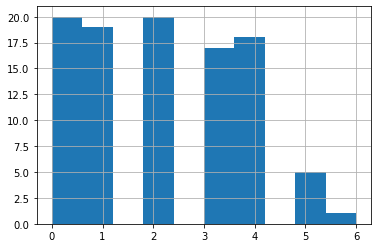

In [44]:
dtrain.target.hist()

<AxesSubplot:>

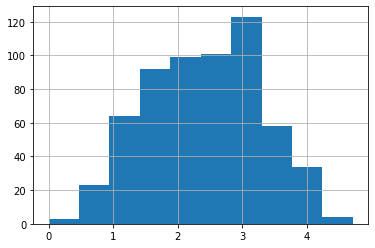

In [45]:
submission.label.hist()

In [46]:
!rm -rf assets
!mkdir assets
submission.to_csv(os.path.join("assets", "submission.csv"))

In [47]:
%load_ext aicrowd.magic
%aicrowd login



The aicrowd.magic extension is already loaded. To reload it, use:
  %reload_ext aicrowd.magic
Please login here: https://api.aicrowd.com/auth/nIlh0hH8gnHLzsZSCsXVjfHBSS0LCR35VnrM6legWTk
Login Error: Couldn't login. Max retries exceeded
Please try logging in again
Using notebook: /mnt/c/Kaggle/AI6/LiDAR/01/08.ipynb for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...
submission.zip ━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 81.4/79.8 KB • 1.7 MB/s • 0:00:00• 0:00:01
                                                   ╭─────────────────────────╮                                                    
                                                   │ Successfully submitted! │                                                    
                                                   ╰─────────────────────────╯                                                    
                                                         Important links                  

https://www.aicrowd.com/challenges/ai-blitz-xi/problems/lidar-car-detection/submissions/new